# Knowledge From Medical Text
## Introduction
#### Problem Statement

Biomedical information systems empower researchers with indexing, search, and inference capabilities that help them leverge prior knowldge to generate new insights and discoveries. However, the datasets and publications that knowledge systems draw upon are biased toward novel and experimental observations, with many basic concepts and associations that are common knowledge in the practice of medicine underreppresented or omitted.  Thus, systems are prone to naive type I and type II errors which researchers or clinicians with even a rudimentary understanding of human physiology would not make.  

#### Need Statement
A way to leverage prior knowledge and augment reasoning for clinicians and biomedical researchers that improves recall of basic physiology and reduces naive errors compared to the current generation of biomedical reasoning systems.

#### Approach

Our hypothesis is that inclusion of knowledge fundamentals of human physiology in biomedical reasoning systems will improve the quality of recall and inference. We use computer vision and natural language processing (NLP) to structure the knowledge contained in medical textbooks into a machine readable database that supports specialized query and inference algorithms.   

## Optical Character Recognition (OCR)
Medical textbooks are distributed electronically in image-like formats that readily admit display, but not manipulation of the underlying text.  In order to apply NLP algorithms, we must preprocess the data into a suitable format, using optical character recognition (OCR) to "read" and transcribe the text.

#### Text Image
Below is an image of content taken from the textbook *"Medical Physiology: Principles for Clinical Medicine"*.

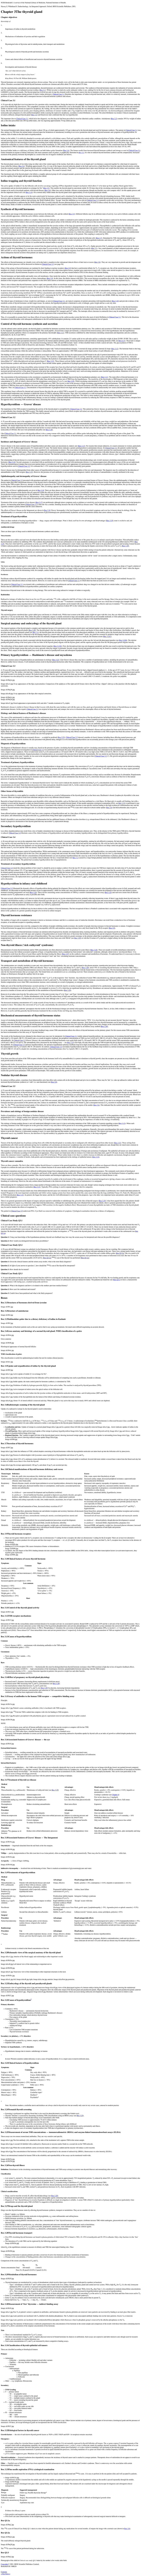

In [1]:
from IPython.display import Image
Image("bookshelf.png")

#### Tesseract OCR
We use the open source OCR engine -- Tesseract -- to extract the text from the image and then save it as a `.txt` file.  Detailed documentation and instsllation instructions for the Tesseract command line tool can be found [here](https://github.com/tesseract-ocr/tesseract).

In [2]:
%%bash
tesseract bookshelf.png bookshelf

Tesseract Open Source OCR Engine v4.0.0 with Leptonica
Estimating resolution as 139


#### Import Sentences
After preprocessing, we import the text file generated by Tesseract into Python and parse it into sentences.  Tesseract seems to do a solid job of extracting the text from the page image.

In [3]:
from pprint import pprint

filename = 'bookshelf.txt'
with open(filename, 'r') as f:
    data = f.read().replace('\n', ' ')
    sentences = data.split('. ')
pprint(sentences[25:30])

['    The important clue to Clinical Case 3.1, which led to her diagnosis, was '
 'the drug she had been prescribed to treat her inherited cardiac condition',
 'Amiodarone (Box 3.2) contains 30% by weight of iodine and, at the dose '
 'prescribed (one 200 mg tablet daily), she was ingesting approximately 70 mg '
 'iodine per day',
 '    Iodine intake  The normal European daily dietary intake of iodine is '
 'about 150 1g, of which approximately 125 ig is taken up by the thyroid gland '
 'and used for hormone synthesis',
 'The patient in Clinical Case 3.1 was, thus, taking over 500 times the normal '
 'intake (released upon the breakdown of amiodarone) resulting in an excess '
 'production and release of thyroid hormones and symptoms of hyperthyroidism',
 'In contrast, lack of iodine in the diet leads to hypothyroidism,  Iodine (as '
 'the iodide, I’ is relatively abundant in seawater and seafood is a rich '
 'dietary source']


## Relation Extraction
Finally, we use the SemRep API to extract entities and relations from the text data.  There is no client library for the SemRep API, so we roll our own using the [requests](http://docs.python-requests.org/en/master/) and [lxml](https://lxml.de/) packages.  Taken together the functions in the section below:
1. Iterate over a list of sentences
2. Upload each to the semrep API
3. Parse the API responses

In [4]:
import requests
import urllib.parse as urlparse
import lxml.etree as etree

# Extract entity information from semrep xml doc 
def parse_entity(entity):
    key = entity.get('id')
    value = {
        'uri' : entity.get('cui'),
#         'mention': entity.get('text'),
        'name': entity.get('name'),
        'categories': entity.get('semtypes')
    }
    return key, value

# Extract predication info from semrep xml doc
def parse_predicate(predicate):
    p_dict = {
        'subj': predicate.find("Subject").get('entityID'),
        'obj': predicate.find("Object").get('entityID'),
        'type': predicate.find("Predicate").get('type'),
        'pos': predicate.find("Predicate").get('indicatorType')
    }
    return p_dict

# Upload text string to semrep API and extract predications from xml response
def extract_relations(sentences):
    semrep_url = 'https://blackboard.ncats.io/ks/umls/api/semrep/'
    relations = []
    for sentence in sentences:
        query_url = semrep_url + urlparse.quote(sentence)
        r = requests.get(query_url)
        if r.status_code != 200:
            continue
        e = etree.fromstring(r.content)
        Entities = e.findall("Document/Utterance/Entity")
        Predicates = e.findall("Document/Utterance/Predication")
        
        entities = {k: v for k, v in map(parse_entity, Entities)}
        for i in map(parse_predicate, Predicates):
            predication = {'sentence': sentence}
            subj_id = i['subj']
            obj_id = i['obj']
            i['subj'] = entities[subj_id]['uri']
            i['obj'] = entities[obj_id]['uri']
            predication['subj'] = entities[subj_id]
            predication['obj'] = entities[obj_id]
            predication['predicate'] = i
            relations.append(predication)
    return relations

#### Query SemRep
Now we execute our code and print out all the predications SemRep was able to find.

In [6]:
relations = extract_relations(sentences)
# for r in relations:
#     print(r['subj']['mention'], r['predicate']['name'].lower(), r['obj']['mention'])

## Conclusion
We have demonstrated the feasibility of extracting and structuring the information contained in a medical textbook into typed subject-predicate-object triples, using off-the-shelf computer vision and natural language processing tools.  Overall, the results looks promising with reasonable sensitivity and specificity.  Future iterations will:
1. Apply to other passages and textbooks
2. Increase the scale of data processing
3. Investigate alternative methods of entitiy and relation extraction. 

## END

In [7]:
nodes, edges = [], []
for r in relations:
    nodes.append(r['subj'])
    nodes.append(r['obj'])
    edges.append(r['predicate'])

In [43]:
import pandas as pd
nodes_df = pd.DataFrame(nodes).drop_duplicates().dropna()
edges_df = pd.DataFrame(edges).drop_duplicates().dropna()

In [44]:
nodes_df['categories'] = nodes_df['categories'].str.split(",", expand=True)[0]

In [45]:
nodes_df.groupby('categories').count().sort_values(by="name", ascending=False)

name  uri
categories           
aapp          41   41
dsyn          41   41
bpoc          31   31
fndg          21   21
neop          19   19
topp          10   10
cell           8    8
sosy           8    8
orch           8    8
elii           7    7
patf           7    7
gngm           7    7
bdsu           6    6
inch           6    6
orgf           6    6
bacs           6    6
horm           5    5
prog           4    4
tisu           4    4
lbpr           4    4
popg           4    4
genf           3    3
phsu           3    3
blor           3    3
famg           3    3
cgab           3    3
medd           3    3
ocdi           2    2
moft           2    2
biof           2    2
podg           2    2
phsf           2    2
npop           2    2
diap           2    2
celf           2    2
bsoj           2    2
aggp           2    2
ortf           1    1
spco           1    1
tmco           1    1
humn           1    1
nnon           1    1
mobd           1    1
irda           1    1
inpo           1    1
hops           1    1
acab           1    1
grup           1    1
ftcn           1    1
food           1    1
antb           1    1
enzy           1    1
emst           1    1
comd           1    1
chvs           1    1
celc           1    1
hlca           1    1

In [46]:
def type_filter(category):
    if category not in ['aapp', 'dsyn', 'bpoc', 'fndg']:
        output = 'other'
    else:
        output = category
    return output

nodes_df['categories'] = nodes_df['categories'].apply(type_filter)

In [47]:
nodes_df.groupby('categories').count().sort_values(by="name", ascending=False)

name  uri
categories           
other        177  177
aapp          41   41
dsyn          41   41
bpoc          31   31
fndg          21   21

In [48]:
nodes_df.to_csv('bookshelf_nodes.csv', columns=['uri','name', 'categories'], index=False)
edges_df.to_csv('bookshelf_edges.csv', columns=['subj','type', 'obj'], index=False)